In [25]:
import os
import pandas as pd
from tqdm import tqdm
import vqa_logger 
import logging
from pathlib import Path
import datetime
from common import DAL
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
logger = logging.getLogger(__name__)

In [26]:
df_models = DAL.get_models_data_frame()
df_models = df_models[['class_strategy', 'parameter_count', 'loss_function', 'trainable_parameter_count','activation', 'notes',]]
# 'model_location',
df_scores = DAL.get_partial_scores_data_frame()
df_question_categories = DAL.get_question_categories_data_frame()
df_evaluation_types = DAL.get_evaluation_types_data_frame()

In [27]:
# df_models.tail()

In [28]:
# df_scores.tail()

In [29]:
# df_question_categories

In [30]:
# df_evaluation_types

In [31]:
df = df_models.join(df_scores, how='inner')\
    .join(df_question_categories, on='question_category_id')\
    .join(df_evaluation_types, on='evaluation_type')\
    .sort_index(ascending=False)


df=df[['Category', 'name', 'score','class_strategy',  'loss_function','activation', 'parameter_count','trainable_parameter_count', 'notes']]
df.head()


,Category,name,score,class_strategy,loss_function,activation,parameter_count,trainable_parameter_count,notes
202,Abnormality,wbss,0.079517,answers,categorical_crossentropy,softmax,20111052,86396,"post_concat_dense_units: (8,);\nOptimizer: RMS..."
202,Abnormality,bleu,0.032323,answers,categorical_crossentropy,softmax,20111052,86396,"post_concat_dense_units: (8,);\nOptimizer: RMS..."
202,Abnormality,strict_accuracy,0.012579,answers,categorical_crossentropy,softmax,20111052,86396,"post_concat_dense_units: (8,);\nOptimizer: RMS..."
201,Abnormality,wbss,0.064820,answers,categorical_crossentropy,softmax,20107949,83297,"post_concat_dense_units: (8, 7, 6);\nOptimizer..."
201,Abnormality,bleu,0.020804,answers,categorical_crossentropy,softmax,20107949,83297,"post_concat_dense_units: (8, 7, 6);\nOptimizer..."


### Get data from notes:

In [32]:
new_columns_data = \
{'post_concat_dense_units': None,
'Optimizer': None,
# 'loss': None,
'activation': None,
'prediction ': None,
'lstm_units': None,
'batch_size': None,
'epochs': None,
'class weights': False,
'Inputs Attention': False}

In [33]:
def note_to_lines(raw):
    n = raw
    for c in [';']:
        n = n.replace(c, '')
    lines = (l.strip() for l in n.split('\n'))
    lines = [l for l in lines if ': ' in l]
    return lines


raw = df.notes.values[0]
lines = note_to_lines(raw)
# print('\n'.join(lines))

def get_data_from_lines(lines, col_name):
    default_val = new_columns_data[col_name]
    relevant_lines = [l for l in lines if col_name in l]
    assert len(relevant_lines) <=1
    if len(relevant_lines) == 0:
        data = default_val
    else:
        line = relevant_lines[0]
        data_str = line.split()[-1]
        try:
            data = eval(data_str)            
        except:
            data = data_str
        
    return data
# print('-'*10)        
# for col in new_columns_data:  
#     data = get_data_from_lines(lines, col)
#     print(f'{col}: {data}')


In [34]:
def notes_to_data(notes, col_name):
    lines =note_to_lines(notes)
    data = get_data_from_lines(lines, col_name)
    return data

for col in new_columns_data:  
    data = notes_to_data(raw, col)
    print(f'{col}: {data}')

post_concat_dense_units: (8,)
Optimizer: RMSprop
activation: softmax
prediction : answers
lstm_units: 128
batch_size: 32
epochs: 3
class weights: False
Inputs Attention: False


In [35]:
for col in new_columns_data:  
    df[col.replace(' ', '_')] = df.notes.apply(lambda notes: notes_to_data(notes, col))    


In [63]:
print(df.Category.drop_duplicates().values)
print(df.name.drop_duplicates().values)

['Abnormality' 'Modality' 'Organ' 'Plane' 'Abnormality_yes_no']
['wbss' 'bleu' 'strict_accuracy']


## Plot results

In [37]:
cmaps = [c for c in dir(plt.cm) if not c.startswith('_')] 
try:
    i += 1
except:
    i = 0

cmap = cmaps[i]
# cmap = "Blues"
# cmap = plt.cm.jet
# cmap ='Accent'
cmap = 'Paired'

In [77]:
category = 'Abnormality'
evaluation = 'strict_accuracy'
cdf = df[(df.Category==category) & (df.name==evaluation)]
print( cdf.columns)
cdf.sample(5)

Index(['Category', 'name', 'score', 'class_strategy', 'loss_function',
       'activation', 'parameter_count', 'trainable_parameter_count', 'notes',
       'post_concat_dense_units', 'Optimizer', 'prediction_', 'lstm_units',
       'batch_size', 'epochs', 'class_weights', 'Inputs_Attention'],
      dtype='object')


,Category,name,score,class_strategy,loss_function,activation,parameter_count,trainable_parameter_count,notes,post_concat_dense_units,Optimizer,prediction_,lstm_units,batch_size,epochs,class_weights,Inputs_Attention
104,Abnormality,strict_accuracy,0.000000,words,cosine_proximity,sigmoid,20092917,59305,"post_concat_dense_units: (7, 8, 6);\nOptimizer...",6),RMSprop,words,0.0,32.0,NaN,False,False
164,Abnormality,strict_accuracy,0.014675,answers,categorical_crossentropy,softmax,20089701,56083,"post_concat_dense_units: (6, 9);\nOptimizer: R...",9),RMSprop,answers,0.0,32.0,12.0,False,False
121,Abnormality,strict_accuracy,0.040000,answers,cosine_proximity,sigmoid,20098270,64654,post_concat_dense_units: [8];\nOptimizer: RMSp...,[8],RMSprop,answers,0.0,32.0,NaN,False,False
124,Abnormality,strict_accuracy,0.048000,answers,cosine_proximity,sigmoid,20089701,56083,"post_concat_dense_units: (6, 9);\nOptimizer: R...",9),RMSprop,answers,0.0,32.0,NaN,False,False
83,Abnormality,strict_accuracy,0.000000,words,cosine_proximity,sigmoid,20098931,65313,"post_concat_dense_units: (7, 9);\nOptimizer: R...",9),RMSprop,words,0.0,32.0,NaN,False,False


In [78]:
x_name = 'parameter_count'
y_name = 'trainable_parameter_count'

# x_name = 'epochs'
# y_name = 'batch_size'

x_name = 'prediction_'
y_name = 'score'

sizes_name = 'trainable_parameter_count'
df_plot = cdf[[x_name, y_name]]
df_plot.loc[:,sizes_name] = (100*cdf[sizes_name])**10

print(cmap)
print(len(cdf))
df_plot.head()

# # create data
# x = df_plot[x_name]#np.random.rand(15)
# y = df_plot[y_name]#x+np.random.rand(15)
# z = df_plot[sizes_name]#x+np.random.rand(15)

Paired
106


,prediction_,score,trainable_parameter_count
202,answers,0.012579,6623230446815674368
201,answers,0.002096,4141980420240572416
186,answers,0.016771,-6716130288661954560
177,answers,0.004193,-4925812092436480000
176,answers,0.000000,-4803609417284059136


In [79]:
is_categorial = df_plot.dtypes[x_name] == object
is_categorial
# df_plot.dtypes

True

Text(0.5, 1.0, "'strict_accuracy' for 'Abnormality'")

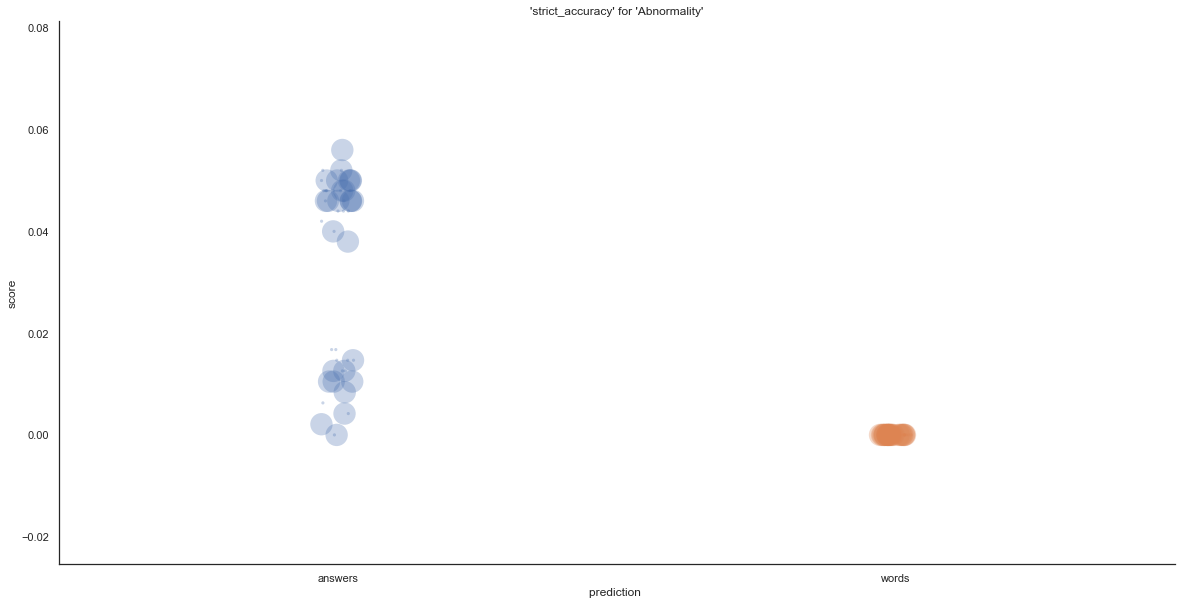

In [80]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
sns.set(style="white", color_codes=True)

sizes=(10, 500)
if is_categorial:
    sns.stripplot(x=x_name, y=y_name, data=cdf, alpha=.3,size=cdf[sizes_name], jitter=0.03, edgecolor='gray', sizes=sizes)# size=z,
else:    
    sns.scatterplot(x=x_name, y=y_name, data=cdf,  hue=x_name, size=sizes_name, palette=cmap, sizes=sizes,  alpha=.3, edgecolor='gray')
    
sns.despine()
 
# Add titles (main and on axis)
plt.xlabel(x_name.replace('_', ' '))
plt.ylabel(y_name.replace('_', ' '))
plt.title(f"'{evaluation}' for '{category}'")
 
# plt.show()
